In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.7.1+cu118
CUDA Available: False


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),   # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# 8x8
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # ---------- Decoder ----------
        self.fc_dec = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 128x128
            nn.Sigmoid())
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        h = self.fc_dec(z)
        h = h.view(x.size(0), 256, 8, 8)

        x_hat = self.decoder(h)
        return x_hat, mu, logvar


In [5]:
def vae_loss(x, x_hat, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl


In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset

class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        return img


In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),   # [0,1]
])

dataset = PneumoniaDataset(
    root_dir="BACTERIAL_PNEUMONIA/train",
    transform=transform
)

from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0

    for x in dataloader:
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}: loss={total_loss / len(dataloader.dataset):.4f}")


cpu


/home/al.igor.alves/DeepExplore/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0: loss=530.2655
Epoch 1: loss=304.3845
Epoch 2: loss=256.7017
Epoch 3: loss=233.1292
Epoch 4: loss=216.2308
Epoch 5: loss=206.1415
Epoch 6: loss=198.7305
Epoch 7: loss=193.2136
Epoch 8: loss=189.8453
Epoch 9: loss=184.9631


In [11]:
x = next(iter(dataloader))
print(x.shape)


torch.Size([32, 1, 128, 128])


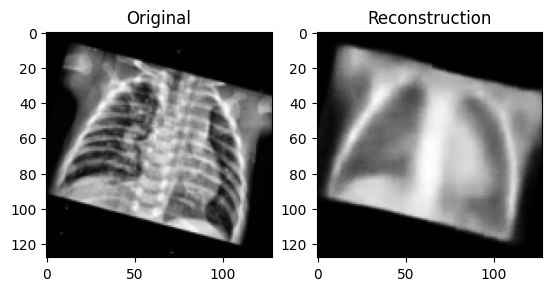

In [29]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    x = next(iter(dataloader))
    x = x.to(device)
    
    # 1. Capture the full output tuple first
    output_tuple = model(x)
    
    # 2. Extract the reconstruction (usually the first item)
    # VAEs typically return: (reconstruction, mu, logvar)
    x_hat_recon = output_tuple[0] 

plt.subplot(1, 2, 1)
# Note: x is on GPU, so .cpu() is required
plt.imshow(x[0, 0].cpu().numpy(), cmap="gray") 
plt.title("Original")

plt.subplot(1, 2, 2)
# 3. Use the extracted reconstruction tensor here
plt.imshow(x_hat_recon[0, 0].cpu().numpy(), cmap="gray")
plt.title("Reconstruction")
plt.show()